In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_theme()

from scipy.stats import ttest_ind
import statsmodels.stats.api as sms

In [2]:
test = pd.read_csv('test_results.csv')
user = pd.read_csv('user_table.csv')

In [3]:
test.head()

,user_id,timestamp,source,device,operative_system,test,price,converted
0,604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39,0
1,624057,2015-05-10 21:08:46,seo-google,mobile,android,0,39,0
2,317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,39,0
3,685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59,0
4,820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,39,0


In [4]:
user.head()

,user_id,city,country,lat,long
0,510335,Peabody,USA,42.53,-70.97
1,89568,Reno,USA,39.54,-119.82
2,434134,Rialto,USA,34.11,-117.39
3,289769,Carson City,USA,39.15,-119.74
4,939586,Chicago,USA,41.84,-87.68


# Data preprocessing

## Data check

In [8]:
test.describe()

,user_id,test,price,converted
count,316800.000000,316800.000000,316800.000000,316800.000000
mean,499281.341840,0.360079,46.205051,0.018333
std,288591.154044,0.480024,9.601487,0.134154
min,3.000000,0.000000,39.000000,0.000000
25%,249525.750000,0.000000,39.000000,0.000000
50%,499021.500000,0.000000,39.000000,0.000000
75%,749025.500000,1.000000,59.000000,0.000000
max,1000000.000000,1.000000,59.000000,1.000000


In [9]:
user.describe()

,user_id,lat,long
count,275616.000000,275616.000000,275616.000000
mean,499245.801521,37.111680,-93.981772
std,288533.458944,5.209627,18.086486
min,3.000000,19.700000,-157.800000
25%,249544.500000,33.660000,-112.200000
50%,498861.000000,37.740000,-88.930000
75%,748856.500000,40.700000,-78.910000
max,999999.000000,61.180000,30.310000


- without missing data

In [10]:
test.groupby('test')['price'].value_counts()

test  price
0     39       202517
      59          210
1     59       113918
      39          155
Name: price, dtype: int64

- some price assigned to control and experimental group are wrong
- the numbers of wrong labelled users are small, can be removed

### Remove the wrong labels

In [14]:
test = test[((test['test']==0) & (test['price']==39)) |
            ((test['test']==1) & (test['price']==59))]

In [15]:
test.groupby('test')['price'].value_counts()

test  price
0     39       202517
1     59       113918
Name: price, dtype: int64

## merge datasets

In [16]:
df = pd.merge(test, user, how='left', on='user_id')

In [17]:
df.head()

,user_id,timestamp,source,device,operative_system,test,price,converted,city,country,lat,long
0,604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39,0,Buffalo,USA,42.89,-78.86
1,624057,2015-05-10 21:08:46,seo-google,mobile,android,0,39,0,Lakeville,USA,44.68,-93.24
2,317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,39,0,Parma,USA,41.38,-81.73
3,685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59,0,Fayetteville,USA,35.07,-78.90
4,820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,39,0,Fishers,USA,39.95,-86.02


In [18]:
df.describe()

,user_id,test,price,converted,lat,long
count,316435.000000,316435.000000,316435.000000,316435.000000,275294.000000,275294.000000
mean,499310.426593,0.360004,46.200088,0.018336,37.112004,-93.981225
std,288593.046579,0.480002,9.600041,0.134162,5.209756,18.086916
min,3.000000,0.000000,39.000000,0.000000,19.700000,-157.800000
25%,249551.000000,0.000000,39.000000,0.000000,33.660000,-112.200000
50%,499047.000000,0.000000,39.000000,0.000000,37.740000,-88.930000
75%,749046.000000,1.000000,59.000000,0.000000,40.700000,-78.910000
max,1000000.000000,1.000000,59.000000,1.000000,61.180000,30.310000


- some users in the test results are not in user table

# Q1: Should the company sell its software for 39 or 59?

In [22]:
df['revenue'] = df['price'] * df['converted']

In [21]:
df.groupby('test')['converted', 'revenue'].mean()

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


,converted,revenue
test,,
0,0.019900,0.776083
1,0.015555,0.917748


## T-test

In [24]:
g0 = df[df['test']==0]['revenue']
g1 = df[df['test']==1]['revenue']

ttest_ind(g1, g0, equal_var=False)

Ttest_indResult(statistic=5.715224666463108, pvalue=1.0972577312420781e-08)

- Revenue of control and expeirmental group are siginifcanlty different.

### Source

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 [Text(0, 0, 'ads_facebook'),
  Text(1, 0, 'seo-google'),
  Text(2, 0, 'ads-bing'),
  Text(3, 0, 'direct_traffic'),
  Text(4, 0, 'ads-google'),
  Text(5, 0, 'seo_facebook'),
  Text(6, 0, 'friend_referral'),
  Text(7, 0, 'ads_other'),
  Text(8, 0, 'ads-yahoo'),
  Text(9, 0, 'seo-yahoo'),
  Text(10, 0, 'seo-bing'),
  Text(11, 0, 'seo-other')])

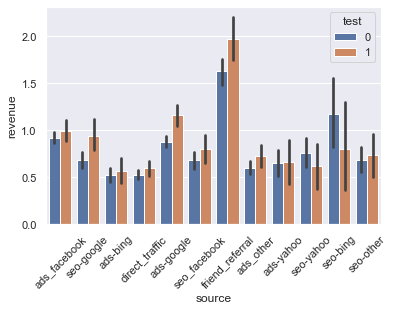

In [32]:
sns.barplot(data=df, x='source', y='revenue', hue='test')
plt.xticks(rotation=45)

- highest revenue
    - friend referal
    - google ads
    - FB ads

- without revenue increase
    - Bing SEO
    - Yahoo SEO
    - Yahoo ads

### Device

<AxesSubplot:xlabel='device', ylabel='revenue'>

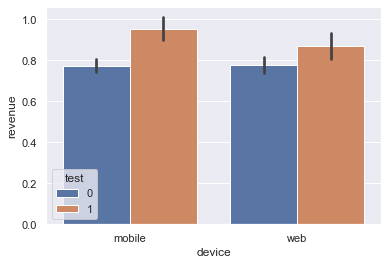

In [34]:
sns.barplot(data=df, x='device', y='revenue', hue='test')

- Mobile users are less price sensitive

### Operative System

<AxesSubplot:xlabel='operative_system', ylabel='revenue'>

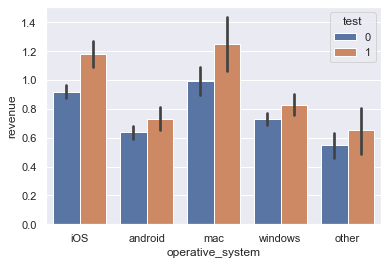

In [40]:
sns.barplot(data=df, x='operative_system', y='revenue', hue='test')

- Apple users are less price sensitive
- There might be some problems assigned the label to Linux users

Remove abnormal data

In [36]:
df['operative_system'].value_counts()

windows    100850
iOS         95353
android     74870
mac         25055
other       16177
linux        4130
Name: operative_system, dtype: int64

In [37]:
df = df[df['operative_system']!='linux']

In [39]:
df.groupby('test')['converted', 'revenue'].mean()

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


,converted,revenue
test,,
0,0.019949,0.778002
1,0.015823,0.933531


In [38]:
g0 = df[df['test']==0]['revenue']
g1 = df[df['test']==1]['revenue']

ttest_ind(g1, g0, equal_var=False)

Ttest_indResult(statistic=6.184240028400434, pvalue=6.253458285742887e-10)

- the difference is still significant

### City

In [41]:
df.head()

,user_id,timestamp,source,device,operative_system,test,price,converted,city,country,lat,long,revenue
0,604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39,0,Buffalo,USA,42.89,-78.86,0
1,624057,2015-05-10 21:08:46,seo-google,mobile,android,0,39,0,Lakeville,USA,44.68,-93.24,0
2,317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,39,0,Parma,USA,41.38,-81.73,0
3,685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59,0,Fayetteville,USA,35.07,-78.90,0
4,820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,39,0,Fishers,USA,39.95,-86.02,0


In [54]:
top_cities = df['city'].value_counts().reset_index().\
rename(columns={'city':'cnt', 'index':'city'}).sort_values('cnt', ascending=False).head(10)['city']

In [55]:
top_cities

0        New York
1         Chicago
2         Houston
3     San Antonio
4     Los Angeles
5        San Jose
6    Indianapolis
7    Jacksonville
8    Philadelphia
9       Las Vegas
Name: city, dtype: object

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'New York'),
  Text(1, 0, 'Chicago'),
  Text(2, 0, 'Las Vegas'),
  Text(3, 0, 'Jacksonville'),
  Text(4, 0, 'Los Angeles'),
  Text(5, 0, 'San Antonio'),
  Text(6, 0, 'Philadelphia'),
  Text(7, 0, 'Houston'),
  Text(8, 0, 'Indianapolis'),
  Text(9, 0, 'San Jose')])

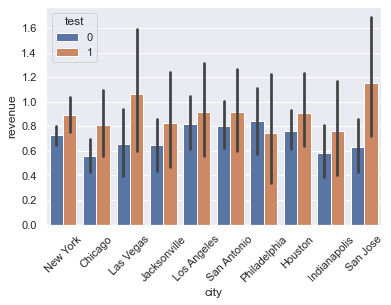

In [57]:
sns.barplot(data=df[df['city'].isin(top_cities)], x='city', y='revenue', hue='test')
plt.xticks(rotation=45)

- Top revenue cities
    - San Jose
    - LA
    - NY

# Q2: After how many days you would have stopped the test?

## Required sample size

- significance level: 0.05
- significance power: 0.8
- expected converion rate: 39/59

In [61]:
conversion_cntl = df[df['test']==0]['converted'].mean()
p1_p2 = sms.proportion_effectsize(conversion_cntl, conversion_cntl*39/59)
sample_size = round(sms.NormalIndPower().solve_power(p1_p2, power=0.8, alpha=0.05))

sample_size

5535

## Required time to collect enough samples

In [71]:
df['week'] = pd.to_datetime(df.timestamp.str.split(' ').str[0]).dt.strftime('%W')

In [75]:
df['week'].value_counts().sort_index()

09    24376
10    23928
11    24130
12    24164
13    23705
14    24519
15    23862
16    23922
17    24039
18    24162
19    23951
20    23721
21    23826
Name: week, dtype: int64

- Remove the fisrt and last week to calculate the avg in case there's less than 7 days in that week

In [83]:
user_week = df[~(df['week'].isin(['09', '21']))].groupby('week')['week'].size().mean()

In [84]:
required_week = sample_size * 2 / user_week

In [85]:
required_week

0.4610701127969012

- only require half of the week the number would be enough

In [87]:
sample_size / (user_week * 2)

0.1152675281992253

- considering the weekly pattern, we run the experiment for 2 weeks
- based on the number of weekly users, the required sample ratio is 11.5%